<span style="font-size:22px;"> Author: Iago Lopes Soares Dias<br>
Email: iagolops2012@gmail.com</span>

<span style="font-size:16px;"> The objective of this notebook is to learn how to use FlexzBoost and verify it's funcionality. To achieve this I executed rail-FlexzBoost using cross-matched data from two spectroscopic catalog, VIPERS and GAMA, with DR2. </span>


# Environment creation

```bash
conda create rail_env
source activate rail_env
pip install pz-rail-flexzboost
python -m ipykernel install --user --name=rail_env
```

## Importing packages and setting notifications

In [97]:

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables_io
import qp
import sys


from matplotlib import gridspec
import seaborn as sns
from qp.metrics.pit import PIT
from IPython.display import Markdown
import h5py
import os
from qp.ensemble import Ensemble
from qp import interp

from rail.evaluation.metrics.base import MetricEvaluator
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from rail.core.data import TableHandle, PqHandle, ModelHandle, QPHandle, DataHandle
from rail.core.util_stages import ColumnMapper, TableConverter
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.estimation.algos.naive_stack import NaiveStackSummarizer
from rail.estimation.algos.point_est_hist import PointEstHistSummarizer

import warnings
warnings.filterwarnings("ignore")

In [1]:
%%javascript # Some configs to notify when the cell run
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

# Flexzboost on DR2 data

This section shows how I trained and validated using FlexzBoost.

## Reading spectroscopic catalog cross-matched

The data used came from 'Controlled_sample.ipynb'.

Choose between GAMA or VIPERS!

In [4]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

In [5]:


catalog = 'VIPERS' # Choose GAMA or VIPERS
training_csv = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/training.control_{catalog}', sep=' ')
validation_csv = pd.read_csv(f'/home/iago.dias/IC_Photo-z/Iago/samples/validation.control_{catalog}', sep=' ')



In [6]:
training_csv

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
0,0.8322,22.896608,22.395735,21.911516,21.816675,21.645422,0.051414,0.040181,0.044053,0.084790,0.200469,0.500874,0.484219,0.094841,0.171253,0.011233,-0.003872,-0.040737,-0.115679
1,0.7499,23.347048,22.369768,21.729416,21.278749,21.759733,0.113855,0.060167,0.060902,0.072633,0.330481,0.977280,0.640352,0.450666,-0.480984,0.053688,-0.000735,-0.011731,-0.257847
2,0.5797,22.775026,21.594164,20.938263,20.507381,20.537544,0.071338,0.030493,0.035033,0.034061,0.110403,1.180862,0.655901,0.430882,-0.030163,0.040845,-0.004541,0.000973,-0.076343
3,0.7642,23.150194,22.375637,21.876324,21.628412,21.961998,0.080405,0.050262,0.051865,0.092243,0.318340,0.774557,0.499313,0.247911,-0.333586,0.030142,-0.001603,-0.040378,-0.226097
4,0.8818,23.191761,22.594900,22.015545,21.719957,21.866032,0.059108,0.045689,0.048919,0.069947,0.236756,0.596861,0.579355,0.295588,-0.146074,0.013419,-0.003229,-0.021028,-0.166809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21868,0.6118,23.400440,22.284716,21.674662,21.704668,21.983829,0.123238,0.055362,0.050605,0.111953,0.384974,1.115725,0.610054,-0.030006,-0.279161,0.067876,0.004757,-0.061348,-0.273021
21869,0.8852,22.733706,22.345627,21.724373,21.527571,22.060930,0.047393,0.044239,0.043205,0.065410,0.302581,0.388079,0.621254,0.196802,-0.533360,0.003154,0.001034,-0.022205,-0.237171
21870,0.5929,23.293682,22.404408,21.981777,21.841465,22.328255,0.088967,0.060065,0.076798,0.105736,0.754651,0.889275,0.422630,0.140312,-0.486790,0.028901,-0.016733,-0.028938,-0.648915
21871,0.5360,24.070980,22.079430,21.347004,20.876230,20.886198,0.146944,0.034227,0.025868,0.036776,0.116476,1.991550,0.732426,0.470774,-0.009968,0.112717,0.008358,-0.010907,-0.079701


In [7]:
validation_csv

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
0,0.5089,23.065063,21.242895,20.577858,20.203987,20.221018,0.079829,0.020170,0.017322,0.023665,0.074703,1.822168,0.665037,0.373871,-0.017031,0.059659,0.002848,-0.006343,-0.051038
1,0.5358,22.947603,21.871132,21.553930,21.310436,21.493093,0.048108,0.024082,0.028427,0.043703,0.160799,1.076471,0.317202,0.243494,-0.182657,0.024026,-0.004345,-0.015276,-0.117096
2,0.7801,23.991873,22.589354,21.376934,20.861425,20.557722,0.149843,0.055428,0.029894,0.034013,0.086669,1.402519,1.212420,0.515509,0.303703,0.094415,0.025534,-0.004119,-0.052657
3,0.4774,23.207233,22.378010,22.097597,22.021200,22.001453,0.058598,0.037236,0.047400,0.080199,0.246480,0.829224,0.280413,0.076397,0.019747,0.021362,-0.010165,-0.032799,-0.166281
4,0.6777,23.152283,22.364990,21.800694,21.656246,21.686739,0.057155,0.037721,0.037023,0.060833,0.196835,0.787292,0.564297,0.144447,-0.030493,0.019434,0.000698,-0.023811,-0.136001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21869,0.4613,23.484598,22.507572,22.240623,22.179319,21.896727,0.092554,0.050321,0.064721,0.133701,0.290423,0.977026,0.266949,0.061304,0.282593,0.042233,-0.014400,-0.068980,-0.156721
21870,0.7446,23.276466,22.582659,22.107471,21.902122,22.485680,0.090939,0.077021,0.080370,0.118301,0.695336,0.693808,0.475187,0.205349,-0.583557,0.013918,-0.003349,-0.037931,-0.577035
21871,0.6583,24.346209,22.559275,21.552792,21.102238,21.240248,0.258576,0.080111,0.051363,0.060356,0.276391,1.786934,1.006483,0.450554,-0.138010,0.178465,0.028748,-0.008993,-0.216035
21872,0.6596,24.648251,22.143084,21.097425,20.634035,20.611952,0.345308,0.055289,0.034194,0.039701,0.156866,2.505167,1.045658,0.463390,0.022083,0.290019,0.021095,-0.005507,-0.117165


### Getting the maximum and minimum redshift from training sample for FlexzBoost configurations

In [8]:

z_max = max(training_csv['#zs'])#,max(validation_csv['#zs']))
z_min = min(training_csv['#zs'])#,min(validation_csv['#zs']))


### Changing columns name according to RAIL

In [9]:
training_csv = training_csv.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)
validation_csv = validation_csv.drop(['g-r','r-i','i-z','z-y','eg-r','er-i','ez-y','ei-z'],axis=1)

In [10]:
columns_map = {
"#zs": "redshift",
"g": "mag_g_lsst",
"eg": "mag_err_g_lsst",
"r": "mag_r_lsst",
"er": "mag_err_r_lsst",
"i": "mag_i_lsst",
"ei": "mag_err_i_lsst",
"y": "mag_y_lsst",
"ey": "mag_err_y_lsst",
"z": "mag_z_lsst",
"ez": "mag_err_z_lsst"
}


col_remapper = ColumnMapper.make_stage(name=f'col_remapper_training_{catalog}', columns=columns_map)

In [11]:
training_sample = col_remapper(training_csv)

Inserting handle into data store.  input: None, col_remapper_training_VIPERS
Inserting handle into data store.  output_col_remapper_training_VIPERS: inprogress_output_col_remapper_training_VIPERS.pq, col_remapper_training_VIPERS


In [12]:
columns = [
    "redshift",
    "mag_g_lsst",
    "mag_r_lsst",
    "mag_i_lsst",
    "mag_z_lsst",
    "mag_y_lsst",
    "mag_err_g_lsst",
    "mag_err_r_lsst",
    "mag_err_i_lsst",
    "mag_err_z_lsst",
    "mag_err_y_lsst"
]

validation_csv.columns = columns

In [13]:
validation_sample = DS.add_data(data=validation_csv, handle_class=PqHandle, key='redshift')

In [16]:
training_sample.data

,redshift,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,0.8322,22.896608,22.395735,21.911516,21.816675,21.645422,0.051414,0.040181,0.044053,0.084790,0.200469
1,0.7499,23.347048,22.369768,21.729416,21.278749,21.759733,0.113855,0.060167,0.060902,0.072633,0.330481
2,0.5797,22.775026,21.594164,20.938263,20.507381,20.537544,0.071338,0.030493,0.035033,0.034061,0.110403
3,0.7642,23.150194,22.375637,21.876324,21.628412,21.961998,0.080405,0.050262,0.051865,0.092243,0.318340
4,0.8818,23.191761,22.594900,22.015545,21.719957,21.866032,0.059108,0.045689,0.048919,0.069947,0.236756
...,...,...,...,...,...,...,...,...,...,...,...
21868,0.6118,23.400440,22.284716,21.674662,21.704668,21.983829,0.123238,0.055362,0.050605,0.111953,0.384974
21869,0.8852,22.733706,22.345627,21.724373,21.527571,22.060930,0.047393,0.044239,0.043205,0.065410,0.302581
21870,0.5929,23.293682,22.404408,21.981777,21.841465,22.328255,0.088967,0.060065,0.076798,0.105736,0.754651
21871,0.5360,24.070980,22.079430,21.347004,20.876230,20.886198,0.146944,0.034227,0.025868,0.036776,0.116476


In [17]:
validation_sample.data

,redshift,mag_g_lsst,mag_r_lsst,mag_i_lsst,mag_z_lsst,mag_y_lsst,mag_err_g_lsst,mag_err_r_lsst,mag_err_i_lsst,mag_err_z_lsst,mag_err_y_lsst
0,0.5089,23.065063,21.242895,20.577858,20.203987,20.221018,0.079829,0.020170,0.017322,0.023665,0.074703
1,0.5358,22.947603,21.871132,21.553930,21.310436,21.493093,0.048108,0.024082,0.028427,0.043703,0.160799
2,0.7801,23.991873,22.589354,21.376934,20.861425,20.557722,0.149843,0.055428,0.029894,0.034013,0.086669
3,0.4774,23.207233,22.378010,22.097597,22.021200,22.001453,0.058598,0.037236,0.047400,0.080199,0.246480
4,0.6777,23.152283,22.364990,21.800694,21.656246,21.686739,0.057155,0.037721,0.037023,0.060833,0.196835
...,...,...,...,...,...,...,...,...,...,...,...
21869,0.4613,23.484598,22.507572,22.240623,22.179319,21.896727,0.092554,0.050321,0.064721,0.133701,0.290423
21870,0.7446,23.276466,22.582659,22.107471,21.902122,22.485680,0.090939,0.077021,0.080370,0.118301,0.695336
21871,0.6583,24.346209,22.559275,21.552792,21.102238,21.240248,0.258576,0.080111,0.051363,0.060356,0.276391
21872,0.6596,24.648251,22.143084,21.097425,20.634035,20.611952,0.345308,0.055289,0.034194,0.039701,0.156866


In [15]:
# saving the data used
#validation_sample.data.to_hdf(f'/home/iago.dias/IC_Photo-z/Iago/samples/validation_control_{catalog}.hdf5',key='data')



## Setting FlexzBoost

Here we can change the configurations of the algorithm.

List of possible regressions:
reg:squarederror // reg:linear // reg:pseudohubererror // reg:absoluteerror

In [18]:
fz_dict = dict(zmin=z_min, zmax=z_max, nzbins=201,
               trainfrac=0.5, bumpmin=0.02, bumpmax=0.35,
               nbump=20, sharpmin=0.7, sharpmax=2.1, nsharp=15,
               max_basis=35, basis_system='cosine',
               bands = ['mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
               err_bands = ['mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
               mag_limits={'mag_g_lsst':24.7,'mag_r_lsst':24.4,'mag_i_lsst':23.8,'mag_z_lsst':23.1,'mag_y_lsst':21.7,},
               hdf5_groupname='',
               regression_params={'max_depth': 8,'objective':'reg:pseudohubererror'})

fz_modelfile = 'demo_FZB_model.pkl'

In [19]:

from rail.estimation.algos.flexzboost import FlexZBoostInformer, FlexZBoostEstimator
inform_pzflex = FlexZBoostInformer.make_stage(name='inform_fzboost', model=fz_modelfile, **fz_dict)



## Training (LONG TIME TO RUN)

If you just want to see the results you can just skip Training and Validation sessions !!!

In [20]:
%%time
inform_pzflex.inform(training_sample)


stacking some data...
read in training data
fit the model...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:47:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

finding best bump thresh...
finding best sharpen parameter...
Retraining with full training set...


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:56:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:56:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:56:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:56:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:56:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

Inserting handle into data store.  model_inform_fzboost: inprogress_demo_FZB_model.pkl, inform_fzboost
CPU times: user 8min 43s, sys: 1min 10s, total: 9min 54s
Wall time: 9min 19s


## Validation (LONG TIME TO RUN)

In [21]:
table_conv = TableConverter.make_stage(name='table_conv_test', output_format='numpyDict');
test_sample_table = table_conv(validation_sample)

Inserting handle into data store.  output_table_conv_test: inprogress_output_table_conv_test.hdf5, table_conv_test


In [22]:
estimate_fzb = FlexZBoostEstimator.make_stage(
    name='estimate_fzb', 
    hdf5_groupname='',
    bands = ['mag_g_lsst','mag_r_lsst','mag_i_lsst','mag_z_lsst','mag_y_lsst'],
    err_bands = ['mag_err_g_lsst','mag_err_z_lsst','mag_err_i_lsst','mag_err_z_lsst','mag_err_y_lsst'],
    mag_limits={'mag_g_lsst':24.7,'mag_r_lsst':24.4,'mag_i_lsst':23.8,'mag_z_lsst':23.1,'mag_y_lsst':21.7,},
    model=inform_pzflex.get_handle('model'),
    filters="path",
    zmax = z_max,
    chunk_size=20
)

In [23]:
%%notify
%%capture
output_fzb = estimate_fzb.estimate(test_sample_table)



<IPython.core.display.Javascript object>

In [44]:
# Saving results

#output_fzb().write_to(f'/home/iago.dias/IC_Photo-z/Iago/results/results_fzb_control_{catalog}_pseudohubererror_100depth.hdf5')



# Data Analysis

This section you can read the files with results and analyze some plots. 

## Results

To check the results insert the pathfile to results in hdf5 format.

### Loading data and preparing for plots

In [137]:
vipers = DS.read_file('pdfs_data', QPHandle, 
                          '/home/iago.dias/IC_Photo-z/Iago/results/results_fzb_control_VIPERS.hdf5')()

gama = DS.read_file('pdfs_data', QPHandle, 
                          '/home/iago.dias/IC_Photo-z/Iago/results/results_fzb_control_GAMA.hdf5')()


In [138]:

############### True redshift #############
ztrue_vipers =  pd.read_hdf('/home/iago.dias/IC_Photo-z/Iago/samples/validation_control_VIPERS.hdf5',key='data')['redshift']
ztrue_gama = pd.read_hdf('/home/iago.dias/IC_Photo-z/Iago/samples/validation_control_GAMA.hdf5',key='data')['redshift']


############### Max redshift ##############
z_max_vipers = vipers.build_tables()['meta']['xvals'][0][-1]
z_max_gama = gama.build_tables()['meta']['xvals'][0][-1]

############ X values for plot ############
zgrid_vipers = np.linspace(0, z_max_vipers, 301)
zgrid_gama = np.linspace(0, z_max_gama, 301)

################## PDFS ##################
pdfs_vipers = vipers.build_tables()['data']['yvals']
pdfs_gama = gama.build_tables()['data']['yvals']


In [139]:
############ TPZ data ##############

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
df_vipers = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/results/results.control_VIPERS.0.mlz',names = column_names, header = None, skiprows =1, sep =' ')
df_gama = pd.read_csv('/home/iago.dias/IC_Photo-z/Iago/results/results.control_GAMA.0.mlz',names = column_names, header= None, skiprows=1, sep =' ')


### Functions to analyze the results

Some functions I selected from 'evaluations_examples/utils.py'.

#### Old_metrics_table

In [41]:
def old_metrics_table(photoz, ztrue, name="", show_dc1=True):
    rows = ["|Metric |", "|:---|", "|scatter |", "|bias |", "|outlier rate |"]
    sigma_iqr, bias, frac, sigma_mad = old_metrics(photoz, ztrue)
    rows[0] += f"{name} |"
    rows[1] += "---:|"
    rows[2] += f"{sigma_iqr:11.4f} |"
    rows[3] += f"{bias:11.5f} |"
    rows[4] += f"{frac:11.3f} |"
    if show_dc1:
        rows[0] += "DC1 paper"
        rows[1] += "---:"
        rows[2] += f"  0.0154"
        rows[3] += f" -0.00027"
        rows[4] += f"  0.020"
    table = ("\n").join(rows)
    return Markdown(table)


In [30]:
def old_metrics(photoz, ztrue):
    point = EvaluatePointStats(photoz, ztrue)
    sigma_iqr = point.CalculateSigmaIQR()
    bias = point.CalculateBias()
    frac = point.CalculateOutlierRate()
    sigma_mad = point.CalculateSigmaMAD()
    return sigma_iqr, bias, frac, sigma_mad

In [29]:

class EvaluatePointStats(object):
    """Copied from PZDC1paper repo. Adapted to remove the cut based on magnitude."""

    def __init__(self, pzvec, szvec):
        """An object that takes in the vectors of the point photo-z
        the spec-z, and the i-band magnitudes for calculating the
        point statistics
        Parameters:
        pzvec: Numpy 1d array of the point photo-z values
        szvec: Numpy 1d array of the spec-z values
        magvec: Numpy 1d array of the i-band magnitudes
        imagcut: float: i-band magnitude cut for the sample
        Calculates:
        ez_all: (pz-sz)/(1+sz), the quantity will be useful for calculating statistics
        ez_magcut: ez sample trimmed with imagcut
        """
        self.pzs = pzvec
        self.szs = szvec
        ez = (pzvec - szvec) / (1. + szvec)
        self.ez_all = ez

    def CalculateSigmaIQR(self):
        """Calculate the width of the e_z distribution
        using the Interquartile range
        Parameters:
        imagcut: float: i-band magnitude cut for the sample
        Returns:
        sigma_IQR_all float: width of ez distribution for full sample
        sigma_IQR_magcut float: width of ez distribution for magcut sample
        """
        x75, x25 = np.percentile(self.ez_all, [75., 25.])
        iqr_all = x75 - x25
        sigma_iqr_all = iqr_all / 1.349
        self.sigma_iqr_all = sigma_iqr_all

        return sigma_iqr_all

    def CalculateBias(self):
        """calculates the bias of the ez and ez_magcut samples.  In
        keeping with the Science Book, this is just the median of the
        ez values
        Returns:
        bias_all: median of the full ez sample
        bias_magcut: median of the magcut ez sample
        """
        bias_all = np.median(self.ez_all)
        return bias_all

    def CalculateOutlierRate(self):
        """Calculates the catastrophic outlier rate, defined in the
        Science Book as the number of galaxies with ez larger than
        max(0.06,3sigma).  This keeps the fraction reasonable when
        sigma is very small.
        Returns:
        frac_all: fraction of catastrophic outliers for full sample
        frac_magcut: fraction of catastrophic outliers for magcut
        sample
        """
        num_all = len(self.ez_all)
        threesig_all = 3.0 * self.sigma_iqr_all
        cutcriterion_all = np.maximum(0.06, threesig_all)
        mask_all = (self.ez_all > np.fabs(cutcriterion_all))
        outlier_all = np.sum(mask_all)
        frac_all = float(outlier_all) / float(num_all)
        return frac_all

    def CalculateSigmaMAD(self):
        """Function to calculate median absolute deviation and sigma
        based on MAD (just scaled up by 1.4826) for the full and
        magnitude trimmed samples of ez values
        Returns:
        sigma_mad_all: sigma_MAD for full sample
        sigma_mad_cut: sigma_MAD for the magnitude cut sample
        """
        tmpmed_all = np.median(self.ez_all)
        tmpx_all = np.fabs(self.ez_all - tmpmed_all)
        mad_all = np.median(tmpx_all)
        sigma_mad_all = mad_all * 1.4826
        return sigma_mad_all


#### plot_old_valid

In [31]:
def plot_old_valid(photoz, ztrue,title, gals=None, colors=None, code=""):
    """Plot traditional Zphot X Zspec and N(z) plots for illustration
    Ancillary function to be used by class Sample.

    Parameters
    ----------
    gals: `list`, (optional)
        list of galaxies' indexes
    colors: `list`, (optional)
        list of HTML codes for colors used in the plot highlighted points
    """
    df = pd.DataFrame({'z$_{true}$': ztrue,
                       'z$_{phot}$': photoz})
    fig = plt.figure(figsize=(10, 4), dpi=100)
    #fig.suptitle(name, fontsize=16)
    ax = plt.subplot(121)
    # sns.jointplot(data=df, x='z$_{true}$', y='z$_{phot}$', kind="kde")
    plt.plot(ztrue, photoz, 'k,', label=code)
    leg = ax.legend(fancybox=True, handlelength=0, handletextpad=0, loc="upper left")
    for item in leg.legendHandles:
        item.set_visible(False)
    if gals:
        if not colors:
            colors = ['r'] * len(gals)
        for i, gal in enumerate(gals):
            plt.plot(ztrue[gal], photoz[gal], 'o', color=colors[i], label=f'Galaxy {gal}')

    plt.plot(ztrue,ztrue,'r--', linewidth =0.5,alpha=0.4)
    zmax = np.max(ztrue) * 1.01
    plt.xlim(0, zmax)
    plt.ylim(0, zmax)
    plt.xlabel('z$_{true}$')
    plt.ylabel('z$_{phot}$')
    plt.subplot(122)
    sns.kdeplot(ztrue, shade=True, label='z$_{true}$')
    sns.kdeplot(photoz, shade=True, label='z$_{phot}$')
    plt.xlim(0, zmax)
    plt.xlabel('z')
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()


#### plot_metrics

In [32]:
def plot_metrics(zspec,
                 zphot,
                 maximum,
                 title=None,
                 initial=0):
    
    '''
    Function to plot Bias, Sigma_68, Out2σ, Out3σ given a spectroscopic and photometric redshift. 
    
    Args:
    
    zspec: Numpy array with the spectroscopic redshift.
    
    zphot: Numpy array with the photometric redshifts calculated. Same size as zspec.
    
    maximum: Float that indicates the redshift max of the plots.
    
    Kwargs:
    
    initial: Float that indicates the redshift min of the plots.
    
    
    
    '''
    
    
    
    
    
    
    bins = np.arange(initial, maximum, 0.1)
    points = bins+0.05
    fraction_outliers = []
    sigma68z = []
    sigmaz=[]
    meanz = []
    outliers_2 = []

    for index in range(len(bins) - 1):
        bin_lower = bins[index]
        bin_upper = bins[index + 1]
        
    
        values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
        values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
        
        

        deltabias = (values_r - values_s)
        mean_bias = np.mean(deltabias)  # Mean bias for each bin
        meanz.append(mean_bias)
        
        
    
        s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
        sigma68 = s[int(len(s)*0.68)]
        sigma68z.append(sigma68)
        
        
        
        sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
        sigmaz.append(sigma)
    
        # Calculate the fraction of outliers outside 3 sigma
        outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
        fraction_outlier = len(outliers) / len(deltabias)
        fraction_outliers.append(fraction_outlier)
        
        
    
        #2 sigma
        outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
        fraction_outlier2 = len(outliers2) / len(deltabias)
        outliers_2.append(fraction_outlier2)



    fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
    plt.subplots_adjust(hspace=0.001) 


    x_lim = (0, np.max(bins))

    # Subplot 1: Mean Bias
    axes[0].plot(points[:-1], meanz, 'bo-')
    axes[0].axhline(0, color='black', linestyle='--')
    axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
    axes[0].set_xlim(x_lim)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].grid(True)

    # Subplot 2: Sigma 68
    axes[1].plot(points[:-1], sigma68z, 'go-')
    axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
    axes[1].set_xlim(x_lim)
    axes[1].axhline(0.12, color='black', linestyle='--')
    #axes[1].set_ylim(0,max(sigmaz)+0.01)
    #axes[1].set_ylim(0, 0.4)
    #axes[1].set_yticks(np.arange(0, 0.5, 0.05))
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].grid(True)


    # Subplot3: 2_outliers
    axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
    #axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
    axes[2].set_xlim(x_lim)
    #axes[2].set_ylim(0,max(outliers_2)+0.01)
    axes[2].axhline(0.1, color='black', linestyle='--')
    axes[2].tick_params(axis='both', labelsize=14)
    axes[2].grid(True)
    axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Subplot 4: 3_outliers
    axes[3].plot(points[:-1], fraction_outliers, 'ro-')
    axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
    axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
    axes[3].set_xlim(x_lim)
    axes[3].set_ylim(0,max(fraction_outliers)+0.01)
    axes[3].axhline(0.015, color='black', linestyle='--')
    axes[3].tick_params(axis='both', labelsize=14)
    axes[3].grid(True)
   

    plt.suptitle(title)
    plt.xlim(0,points[-1])
    plt.tight_layout()
    
    #plt.savefig('/home/iago.dias/IC_Photo-z/Files png/metrics.png')
    

    plt.show()

    

#### Plot_scatter

In [33]:
def plot_scatter(zspec,zphot,catalog):
    kde = gaussian_kde([zspec, zphot])

    x_min, x_max = min(zspec), max(zspec)
    y_min, y_max = min(zphot), max(zphot)
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    z = kde(np.vstack([x.ravel(), y.ravel()]))
    plt.figure(figsize=(8,6))


    plt.plot(zspec,zspec,'r--', linewidth =0.5)


    plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
    colorbar = plt.colorbar()
    colorbar.set_label('Density', fontsize=20)

    plt.xlim(min(zphot), max(zphot))
    plt.ylim(min(zphot), max(zphot))
    plt.title(f'FzBoost_{catalog}')

    plt.xlabel(r'$z_{spec}$', fontsize=22)
    plt.ylabel(r'$z_{phot}$',fontsize=22)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)


    plt.show()

#### Plot_pit_qq

In [114]:
def plot_pit_qq(pdfs, zgrid, ztrue, bins=None, title=None, code=None,
                show_pit=True, show_qq=True,
                pit_out_rate=None, savefig=False) -> str:
    """Quantile-quantile plot
    Ancillary function to be used by class Metrics.

    Parameters
    ----------
    pit: `PIT` object
        class from metrics.py
    bins: `int`, optional
        number of PIT bins
        if None, use the same number of quantiles (sample.n_quant)
    title: `str`, optional
        if None, use formatted sample's name (sample.name)
    label: `str`, optional
        if None, use formatted code's name (sample.code)
    show_pit: `bool`, optional
        include PIT histogram (default=True)
    show_qq: `bool`, optional
        include QQ plot (default=True)
    pit_out_rate: `ndarray`, optional
        print metric value on the plot panel (default=None)
    savefig: `bool`, optional
        save plot in .png file (default=False)
    """

    if bins is None:
        bins = 100
    if title is None:
        title = ""

    if code is None:
        code = ""
        label = ""
    else:
        label = code + "\n"


    if pit_out_rate is not None:
        try:
            label += "PIT$_{out}$: "
            label += f"{float(pit_out_rate):.4f}"
        except:
            print("Unsupported format for pit_out_rate.")

    plt.figure(figsize=[4, 5])
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    sample = Sample(pdfs, zgrid, ztrue)

    if show_qq:
        ax0.plot(sample.qq[0], sample.qq[1], c='r',
                 linestyle='-', linewidth=3, label=label)
        ax0.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=2)
        ax0.set_ylabel("Q$_{data}$", fontsize=18)
        plt.ylim(-0.001, 1.001)
    plt.xlim(-0.001, 1.001)
    plt.title(title)
    if show_pit:
        fzdata = Ensemble(interp, data=dict(xvals=zgrid, yvals=pdfs))
        pitobj = PIT(fzdata, ztrue)
        pit_vals = np.array(pitobj.pit_samps)
        pit_out_rate = pitobj.evaluate_PIT_outlier_rate()

        try:
            y_uni = float(len(pit_vals)) / float(bins)
        except:
            y_uni = float(len(pit_vals)) / float(len(bins))
        if not show_qq:
            ax0.hist(pit_vals, bins=bins, alpha=0.7, label=label)
            ax0.set_ylabel('Number')
            ax0.hlines(y_uni, xmin=0, xmax=1, color='k')
            plt.ylim(0, )  # -0.001, 1.001)
        else:
            ax1 = ax0.twinx()
            ax1.hist(pit_vals, bins=bins, alpha=0.7)
            ax1.set_ylabel('Number')
            ax1.hlines(y_uni, xmin=0, xmax=1, color='k')
    leg = ax0.legend(handlelength=0, handletextpad=0, fancybox=True)
    for item in leg.legendHandles:
        item.set_visible(False)
    if show_qq:
        ax2 = plt.subplot(gs[1])
        ax2.plot(sample.qq[0], (sample.qq[1] - sample.qq[0]), c='r', linestyle='-', linewidth=3)
        plt.ylabel("$\Delta$Q", fontsize=18)
        ax2.plot([0, 1], [0, 0], color='k', linestyle='--', linewidth=2)
        plt.xlim(-0.001, 1.001)
        plt.ylim(np.min([-0.12, np.min(sample.qq[1] - sample.qq[0]) * 1.05]),
                 np.max([0.12, np.max(sample.qq[1] - sample.qq[0]) * 1.05]))
    if show_pit:
        if show_qq:
            plt.xlabel("Q$_{theory}$ / PIT Value", fontsize=18)
        else:
            plt.xlabel("PIT Value", fontsize=18)
    else:
        if show_qq:
            plt.xlabel("Q$_{theory}$", fontsize=18)
    if savefig:
        fig_filename = str("plot_pit_qq_" +
                           f"{(code).replace(' ', '_')}.png")
        plt.savefig(fig_filename)
    else:
        fig_filename = None

    return fig_filename


class Sample(Ensemble):
    """ Expand qp.Ensemble to append true redshifts
    array, metadata, and specific plots. """

    def __init__(self, pdfs, zgrid, ztrue, photoz_mode=None, code="", name="", n_quant=100):
        """Class constructor

        Parameters
        ----------
        pdfs: `ndarray`
            photo-z PDFs array, shape=(Ngals, Nbins)
        zgrid: `ndarray`
            PDF bins centers, shape=(Nbins,)
        ztrue: `ndarray`
            true redshifts, shape=(Ngals,)
        photoz_mode: `ndarray`
            photo-z (PDF mode), shape=(Ngals,)
        code: `str`, (optional)
            algorithm name (for plot legends)
        name: `str`, (optional)
            sample name (for plot legends)
        """

        super().__init__(interp, data=dict(xvals=zgrid, yvals=pdfs))
        self._pdfs = pdfs
        self._zgrid = zgrid
        self._ztrue = ztrue
        self._photoz_mode = photoz_mode
        self._code = code
        self._name = name
        self._n_quant = n_quant
        self._pit = None
        self._qq = None


    @property
    def code(self):
        """Photo-z code/algorithm name"""
        return self._code

    @property
    def name(self):
        """Sample name"""
        return self._name

    @property
    def ztrue(self):
        """True redshifts array"""
        return self._ztrue

    @property
    def zgrid(self):
        """Redshift grid (binning)"""
        return self._zgrid

    @property
    def photoz_mode(self):
        """Photo-z (mode) array"""
        return self._photoz_mode

    @property
    def n_quant(self):
        return self._n_quant

    @property
    def pit(self):
        if self._pit is None:
            pit_array = np.array([self[i].cdf(self.ztrue[i])[0][0] for i in range(len(self))])
            self._pit = pit_array
        return self._pit

    @property
    def qq(self, n_quant=100):
        q_theory = np.linspace(0., 1., n_quant)
        q_data = np.quantile(self.pit, q_theory)
        self._qq = (q_theory, q_data)
        return self._qq

    def __len__(self):
        if len(self._ztrue) != len(self._pdfs):
            raise ValueError("Number of pdfs and true redshifts do not match!!!")
        return len(self._ztrue)

    def __str__(self):
        code_str = f'Algorithm: {self._code}'
        name_str = f'Sample: {self._name}'
        line_str = '-' * (max(len(code_str), len(name_str)))
        text = str(line_str + '\n' +
                   name_str + '\n' +
                   code_str + '\n' +
                   line_str + '\n' +
                   f'{len(self)} PDFs with {len(self.zgrid)} probabilities each \n' +
                   f'qp representation: {self.gen_class.name} \n' +
                   f'z grid: {len(self.zgrid)} z values from {np.min(self.zgrid)} to {np.max(self.zgrid)} inclusive')
        return text

### Zspec x Zphot and N(z)

Here you can choose between mean or mode

In [42]:
median_vipers = vipers.median()
mode_vipers = vipers.mode(zgrid_vipers)
median_gama = gama.median()
mode_gama = gama.mode(zgrid_gama)


########## Median or mode of PDF ##########

zphot_vipers  = np.array([valor for sublista in median_vipers for valor in sublista]) # Choose mode or median
zphot_gama  = np.array([valor for sublista in median_gama for valor in sublista]) # Choose mode or median


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


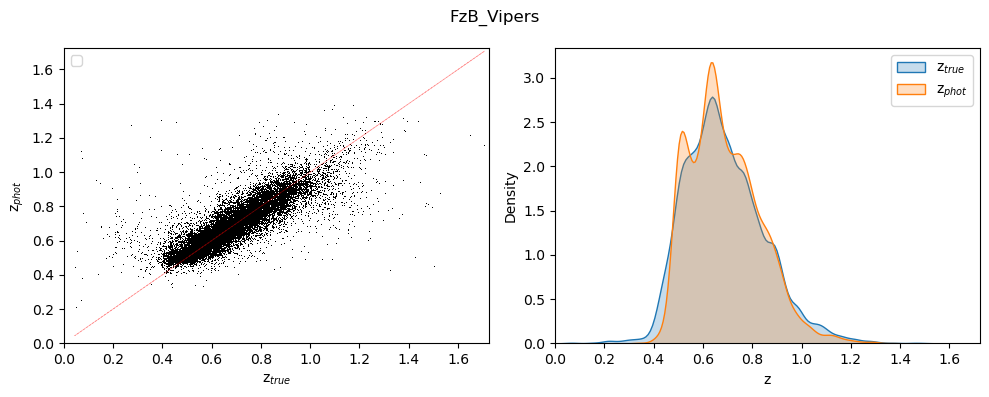

In [43]:
plot_old_valid(zphot_vipers,ztrue_vipers,'FzB_Vipers')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


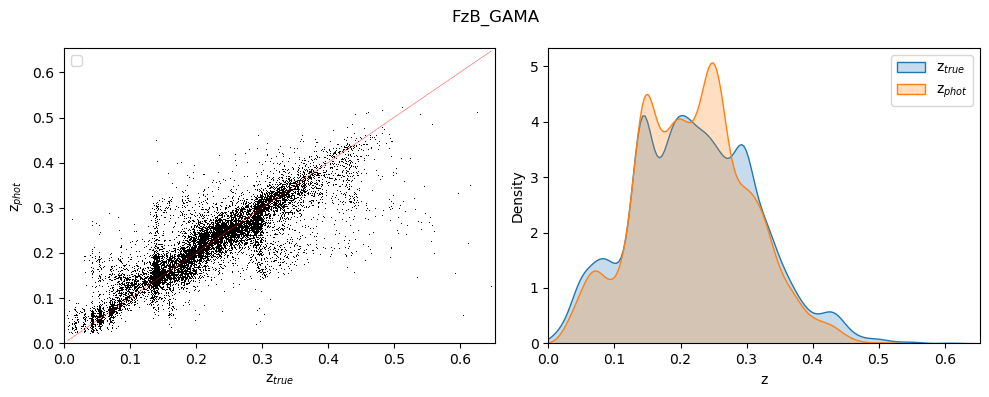

In [36]:
plot_old_valid(zphot_gama,ztrue_gama,'FzB_GAMA')

For TpZ

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


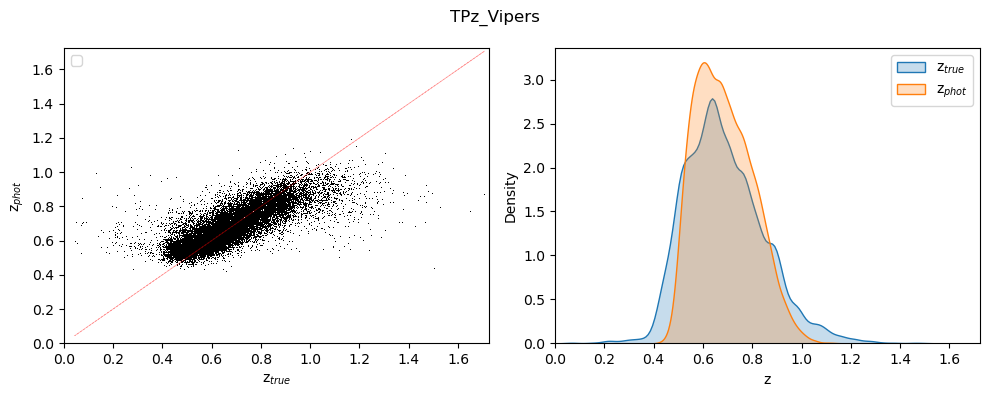

In [149]:
plot_old_valid(df_vipers['zmean1'],df_vipers['ztrue'],'TPz_Vipers')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


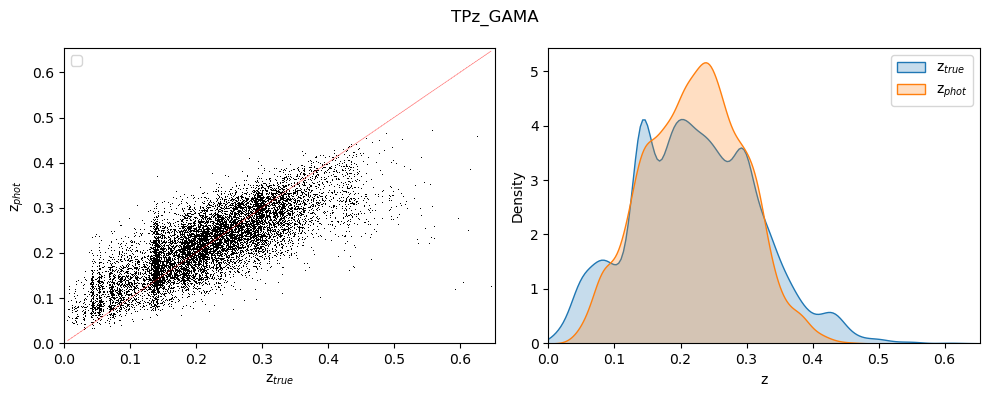

In [150]:
plot_old_valid(df_gama['zmean1'],df_gama['ztrue'],'TPz_GAMA')

### PIT and QQ plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


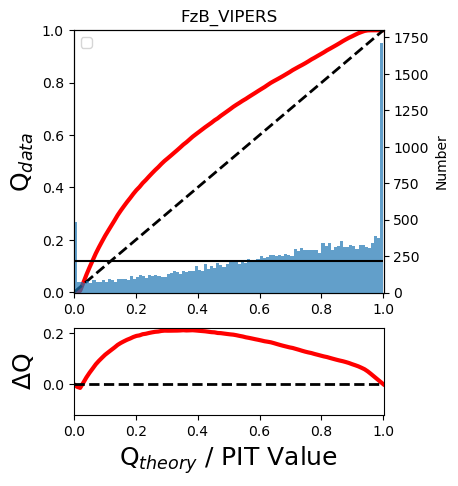

In [158]:
plot_pit_qq(pdfs_vipers,zgrid_vipers,ztrue_vipers,title='FzB_VIPERS')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


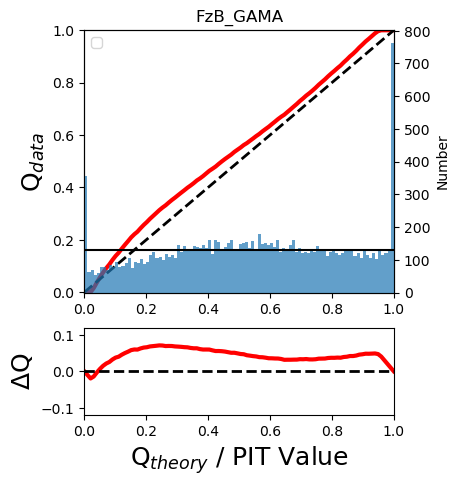

In [159]:
plot_pit_qq(pdfs_gama,zgrid_gama,ztrue_gama,title='FzB_GAMA')

### Metrics

In [154]:
old_metrics_table(zphot_vipers,ztrue_vipers)

|Metric | |DC1 paper
|:---|---:|---:
|scatter |     0.0345 |  0.0154
|bias |    0.00005 | -0.00027
|outlier rate |      0.027 |  0.020

In [155]:
old_metrics_table(zphot_gama,ztrue_gama)

|Metric | |DC1 paper
|:---|---:|---:
|scatter |     0.0222 |  0.0154
|bias |   -0.00014 | -0.00027
|outlier rate |      0.036 |  0.020

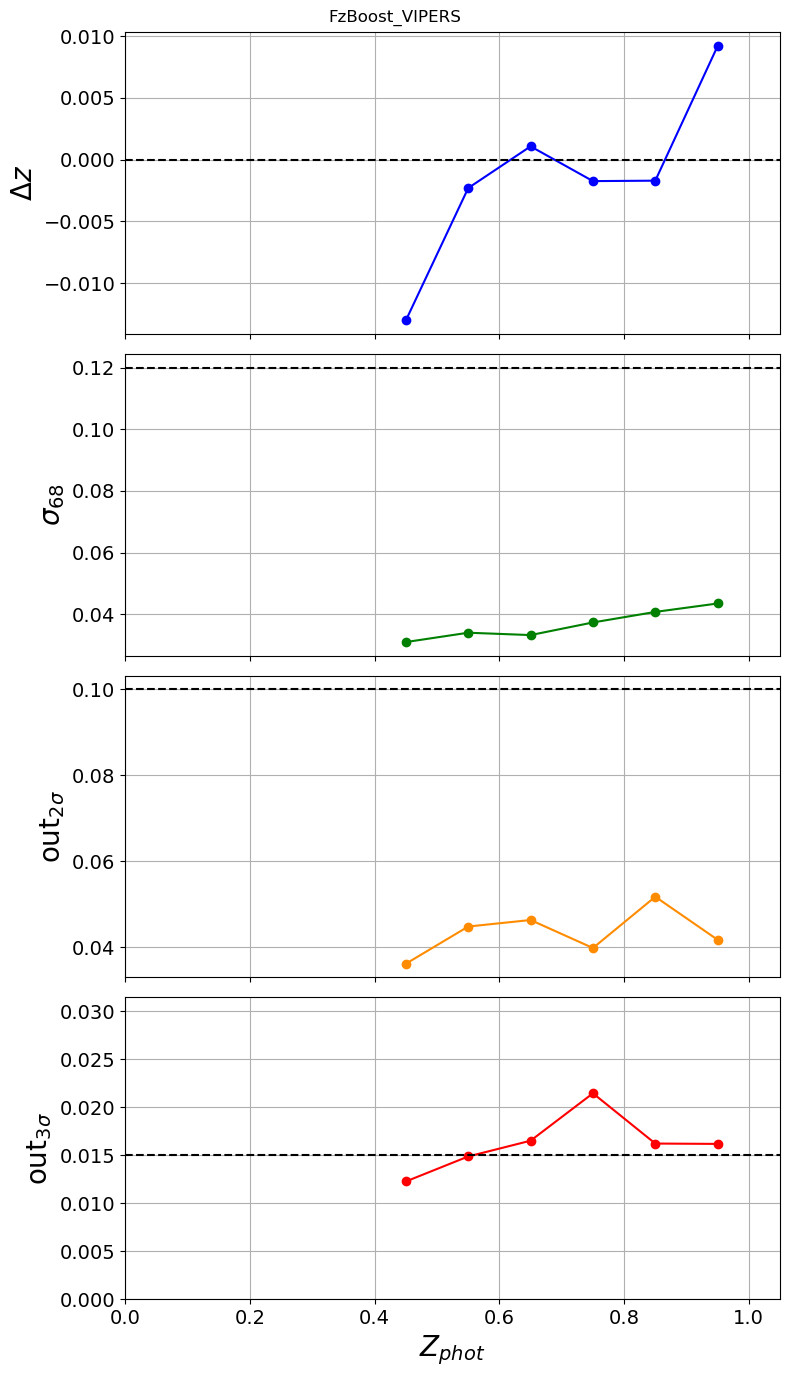

In [156]:
plot_metrics(ztrue_vipers,zphot_vipers,1.1,initial=0.4,title=f'FzBoost_VIPERS')

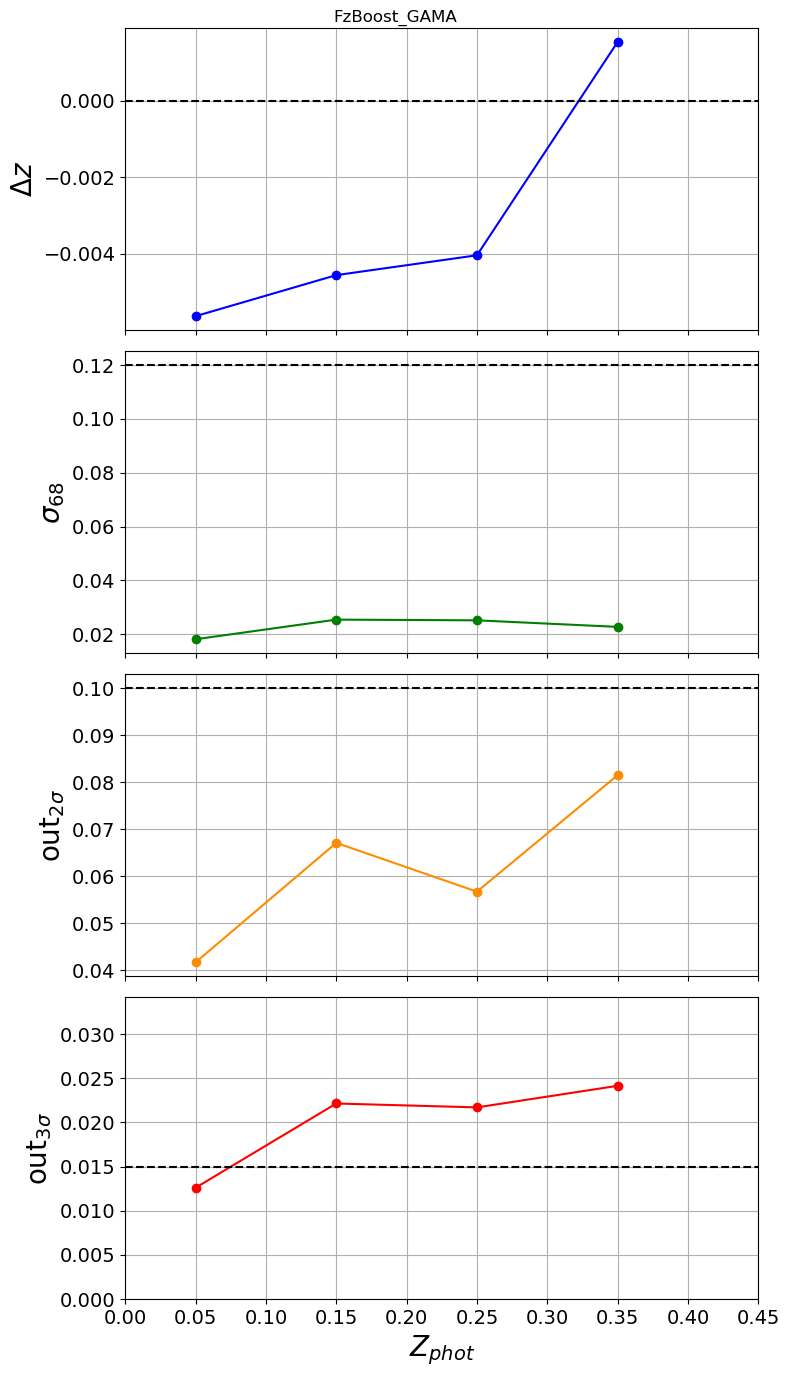

In [157]:
plot_metrics(ztrue_gama,zphot_gama,0.5,initial=0,title=f'FzBoost_GAMA')